<a href="https://colab.research.google.com/github/Uche6/Causality-Research/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries into the program and loading a csv data file into the dataframe

In [0]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import scipy

    
# Assigning a variable to the csv file and laoding it into the dataframe
file = "nonlinear.csv"
df = pd.read_csv(file)


Time lag code that creates four time series columns for each variable in the data file



In [0]:
def renameColumn(column, appendString):
  return column +"_"+ appendString

#take column and shift it downwards with lag = n, creating a new column
def timeLag(dataframe, variables = [], maxLag = 4, loopBack = True, replaceNaN = None): #lag in months*
  
  data = dataframe.copy() #make a copy of dataframe
  for variable in variables:
    
    columnData = pd.DataFrame(dataframe[variable]) #look at the column we want to shift

    if(loopBack):
      for i in range(1, maxLag+1):
        tempLag = np.roll(columnData , i) #cycling dataframe

        newCol = pd.DataFrame(tempLag)
        newName = renameColumn(variable, str(i))
        data[newName] = newCol
        
    else:
      for i in range(1, maxLag+1):
        tempLag = columnData.shift(i)

        newCol = pd.DataFrame(tempLag)

        #optional: replace NaN values with your own value
        if(replaceNaN is not None):
          newCol = newCol.fillna(value=replaceNaN)

        newName = renameColumn(variable, str(i))
        data[newName] = newCol
  return data

Creating X and Y variables for the testing and training data. X1 for regression model one and X2 for regression model two

In [0]:
y = df['x3']

t = timeLag(df, ['x1','x3'], 4)
X2 = t.drop(['x1', 'x2', 'x3', 'x4'], axis=1)

d = timeLag(df, ['x3'], 4)
X1 = d.drop(['x1', 'x2', 'x3', 'x4'], axis=1)

print(X1.head())

print(X2.head())


       x3_1      x3_2      x3_3      x3_4
0 -2.463273 -0.858650  1.586954 -0.918498
1  0.000000 -2.463273 -0.858650  1.586954
2  0.869836  0.000000 -2.463273 -0.858650
3  0.583467  0.869836  0.000000 -2.463273
4  0.538799  0.583467  0.869836  0.000000
       x1_1      x1_2      x1_3  ...      x3_2      x3_3      x3_4
0  1.275641  0.008898  0.003036  ... -0.858650  1.586954 -0.918498
1  0.000000  1.275641  0.008898  ... -2.463273 -0.858650  1.586954
2  9.898728  0.000000  1.275641  ...  0.000000 -2.463273 -0.858650
3  9.529352  9.898728  0.000000  ...  0.869836  0.000000 -2.463273
4  0.772773  9.529352  9.898728  ...  0.583467  0.869836  0.000000

[5 rows x 8 columns]


Maxlag is the number of time lagged data, N is the overall sample size and K denotes the number of groups. These variables are used to calculate the F-test


The XGBReqressor() is used to create parameters for the regression models. n_estimators are the number of boosted trees, colesample_bytree is the subsample ratio of columns when constructing each tree, learning_rate is the boosting tree learning rate, max_depth is the maximum tree depth for base learners and alpha is regularization term on weights.

In [0]:
maxlag = 4
n = df.shape[0]
k = 2

xg_reg1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.1, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.1, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)


Fiting the dataset variables and calculating the mean sqaured error


In [0]:
model1 = xg_reg1.fit(X1,y)
model2 = xg_reg2.fit(X2,y)

preds1 = xg_reg1.predict(X1)
preds2 = xg_reg2.predict(X2)

mse1 = np.mean((preds1 - y)**2)
mse2 = np.mean((preds2 - y)**2)


Printing the model accuracy score and mean squared error for both regresiion models

In [0]:
print ("Model Accuracy Score:", model1.score(X1, y))
print("Mean Squared Error/Deviation: ", np.mean((preds1 - y)**2))

print ("Model Accuracy Score:", model2.score(X2, y))
print("Mean Squared Error/Deviation: ", np.mean((preds2 - y)**2))

Model Accuracy Score: 0.47080147568331676
Mean Squared Error/Deviation:  0.5930561902851995
Model Accuracy Score: 0.5819777746661186
Mean Squared Error/Deviation:  0.46846439855659594


Calculating and printing the p-value and f-*score*

In [0]:
f_score = ((mse1-mse2)/mse2)*((n-k*maxlag)/maxlag)
print('f score: ', f_score)
p_value = scipy.stats.f.sf(f_score, maxlag, n-k*maxlag)
print("the p_value is: ", p_value)

f score:  65.95755076350963
the p_value is:  1.667532947452626e-49


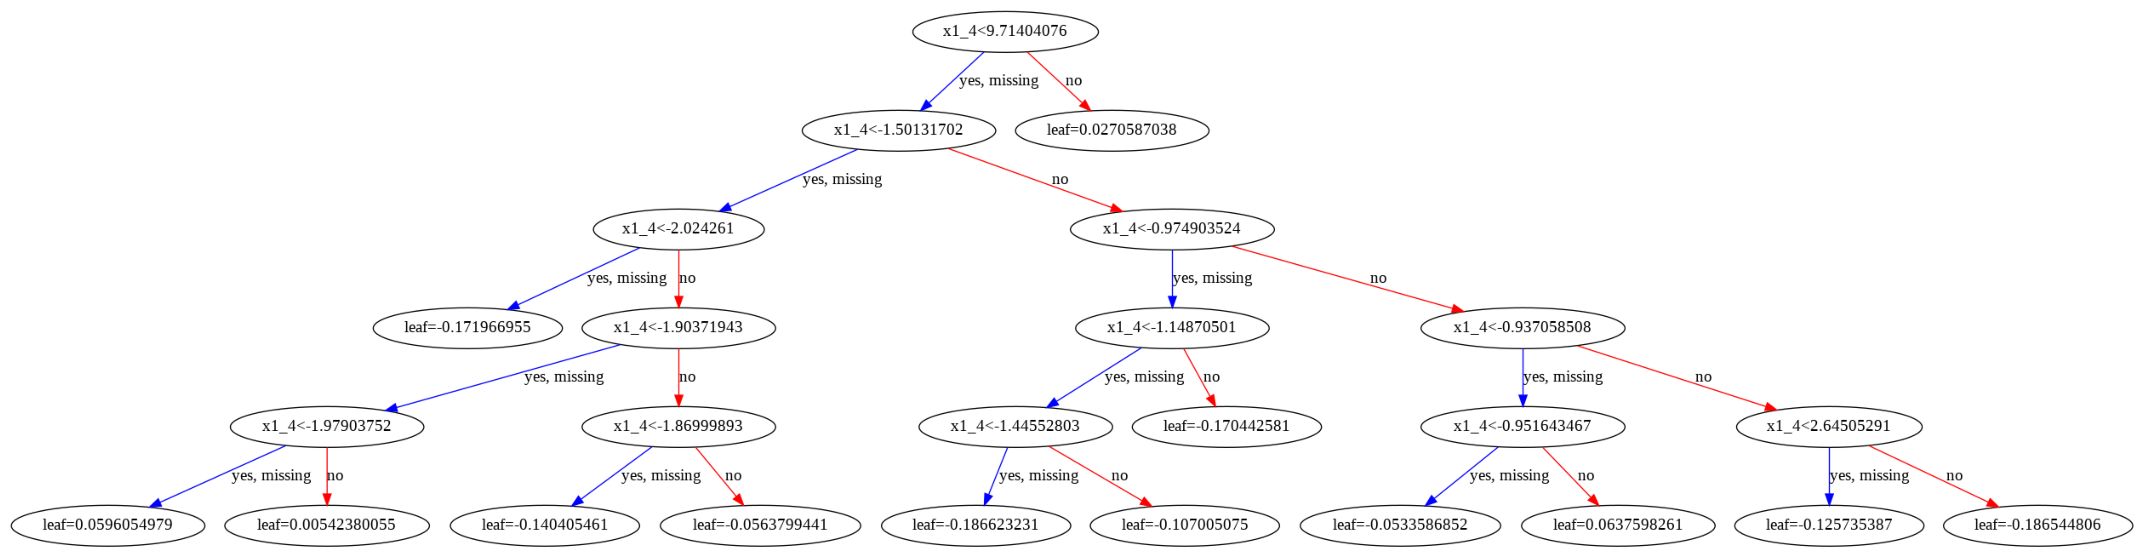

In [0]:
xgb.plot_tree(xg_reg2,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()